# Lab 1: Probability & Descriptive Statistics

Focus: explore core descriptive statistics and dependence concepts using simple synthetic data.

You will:

- Generate and compare a skewed and a roughly normal sample
- Compute mean, variance, sd, skewness, kurtosis
- Compare biased vs unbiased variance estimators
- Examine covariance & correlation (marketing vs revenue)
- Simulate a high-correlation (ρ = 0.90) two-asset return setting
- Study sampling distributions of asset and portfolio means

Open in Google Colab: [Link](https://colab.research.google.com/drive/1uhmvrNuajt2x5HhMpDcJlIaRA6dHfU0S?usp=sharing)

Alternatively, copy and paste the code below into RStuido Desktop or RStudio Cloud.

## Datasets

Synthetic generators used:

- Right-skewed transaction values (log-normal)
- Approx. normal reference sample
- Two correlated asset return series (ρ = 0.90) for sampling exercises

## Instructions

Run each cell sequentially. Read the comments carefully.


In [57]:
# ---- Setup: packages & helper (minimized) ----
req <- c("moments", "ggplot2", "dplyr")
inst <- req[!req %in% installed.packages()[, "Package"]]
if (length(inst) > 0) install.packages(inst)

lapply(req, library, character.only = TRUE)

set.seed(123)  # reproducibility
options(repr.plot.width = 12, repr.plot.height = 4)  # wider default figures

quick_summary <- function(x) {
  data.frame(
    n = length(x),
    mean = mean(x),
    sd = sd(x),
    var = var(x),
    skewness = moments::skewness(x),
    kurtosis = moments::kurtosis(x),
    row.names = NULL
  )
}
print("Setup complete (packages: moments, ggplot2, dplyr).")

[[1]]
 [1] "patchwork" "tibble"    "dplyr"     "ggplot2"   "moments"   "stats"    
 [7] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"     

[[2]]
 [1] "patchwork" "tibble"    "dplyr"     "ggplot2"   "moments"   "stats"    
 [7] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"     

[[3]]
 [1] "patchwork" "tibble"    "dplyr"     "ggplot2"   "moments"   "stats"    
 [7] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"

[1] "Setup complete (packages: moments, ggplot2, dplyr)."


In [58]:
# ---- Data generation ----
skewed_sample <- rlnorm(1000, meanlog = 2, sdlog = 0.5)  # log-normal (positively skewed)
normal_sample <- rnorm(1000, mean = 20, sd = 5)

cat('Preview: first 6 rows of skewed (right-tailed) vs approximately normal sample.\n')
head(data.frame(skewed_sample, normal_sample))

Preview: first 6 rows of skewed (right-tailed) vs approximately normal sample.


,skewed_sample,normal_sample
,<dbl>,<dbl>
1,16.108614,19.910099
2,7.654198,19.339124
3,7.882490,7.253286
4,17.418494,25.202867
5,9.304127,21.248629
6,3.925404,32.081037


In [59]:
# ---- Descriptive statistics ----
summary_skewed <- quick_summary(skewed_sample)
summary_normal <- quick_summary(normal_sample)

cat('Comparison of key statistics: note higher skewness & kurtosis for log-normal sample.\n')
bind_rows(
  skewed = summary_skewed,
  normal = summary_normal,
  .id = "distribution"
)

Comparison of key statistics: note higher skewness & kurtosis for log-normal sample.


distribution,n,mean,sd,var,skewness,kurtosis
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
skewed,1000,8.428385,4.496494,20.21846,1.64801605,7.072802
normal,1000,20.221132,5.043640,25.43830,-0.01362832,2.942717


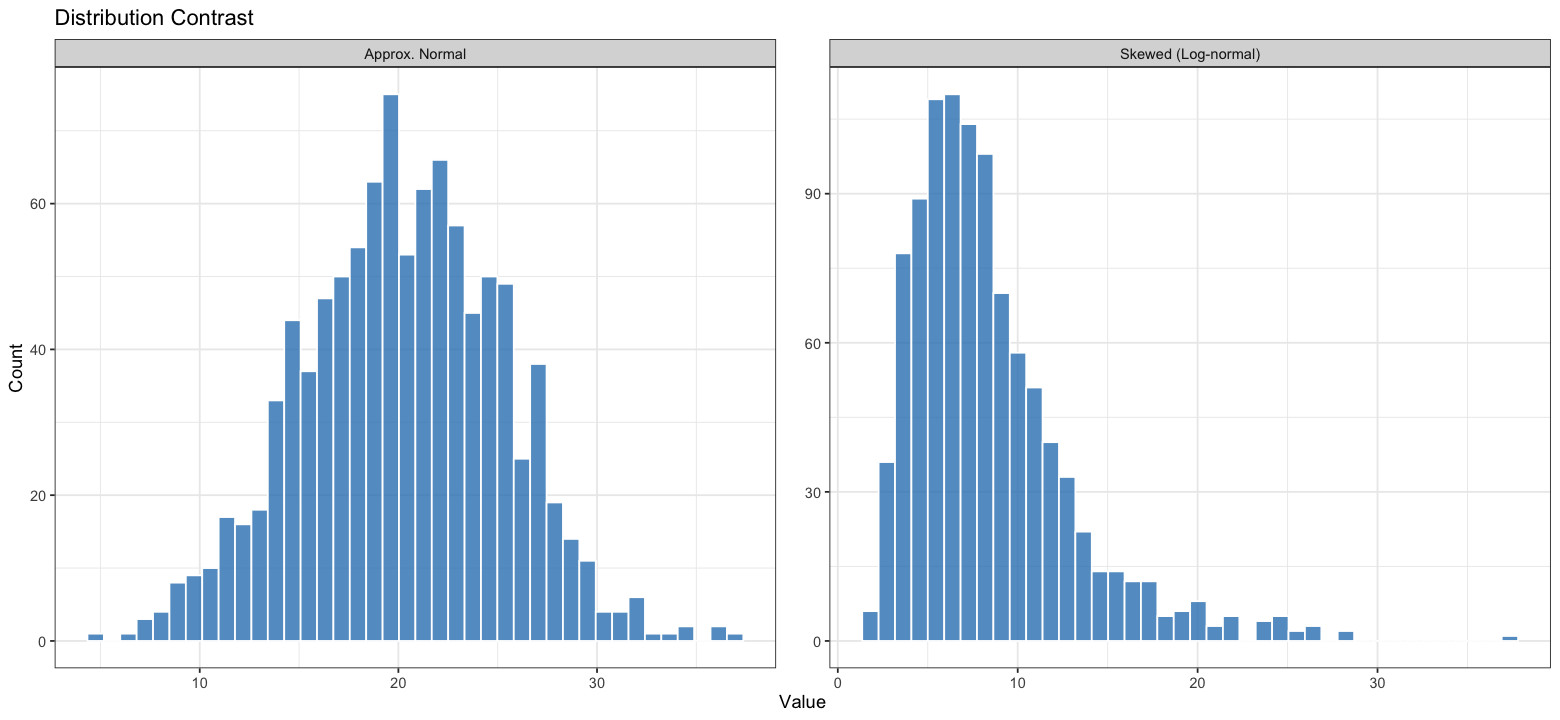

In [60]:
# ---- Visualization: Histograms ----
combined <- rbind(
  data.frame(value = skewed_sample, type = "Skewed (Log-normal)"),
  data.frame(value = normal_sample, type = "Approx. Normal")
)

options(repr.plot.width = 13, repr.plot.height = 6)

ggplot(combined, aes(value)) +
  geom_histogram(bins = 40, fill = "#3182bd", alpha = 0.8, color = "white") +
  facet_wrap(~ type, scales = "free", nrow = 1) +
  labs(title = "Distribution Contrast", x = "Value", y = "Count") +
  theme(panel.spacing.x = unit(1.2, "lines"))

In [61]:
# ---- Covariance & Correlation example ----
# Suppose revenue depends on marketing spend with noise
marketing_spend <- rnorm(100, mean = 50, sd = 10)
revenue <- 5 + 1.8 * marketing_spend + rnorm(100, sd = 15)

cat('Covariance & correlation between marketing spend and revenue (positive association expected).\n')
summary_df <- data.frame(cov = cov(marketing_spend, revenue), cor = cor(marketing_spend, revenue))
summary_df

Covariance & correlation between marketing spend and revenue (positive association expected).


cov,cor
<dbl>,<dbl>
149.4054,0.7856426


In [62]:
# ---- Simulation: Sample vs Population variance ----
true_var <- 25  # sd^2 with sd=5
sample_sizes <- c(5, 10, 20, 50, 100, 250, 500)
results <- lapply(sample_sizes, function(n){
  x <- rnorm(n, mean = 0, sd = 5)
  data.frame(n = n, var_n = mean((x - mean(x))^2), var_n1 = var(x))
}) %>% dplyr::bind_rows()
cat('Variance estimators: var_n (biased, divide by n) vs var_n1 (unbiased, divide by n-1).\n')
results

Variance estimators: var_n (biased, divide by n) vs var_n1 (unbiased, divide by n-1).


n,var_n,var_n1
<dbl>,<dbl>,<dbl>
5,15.17886,18.97357
10,26.34624,29.27360
20,16.53123,17.40129
50,21.11229,21.54315
100,23.98626,24.22854
250,25.38000,25.48193
500,25.58307,25.63434


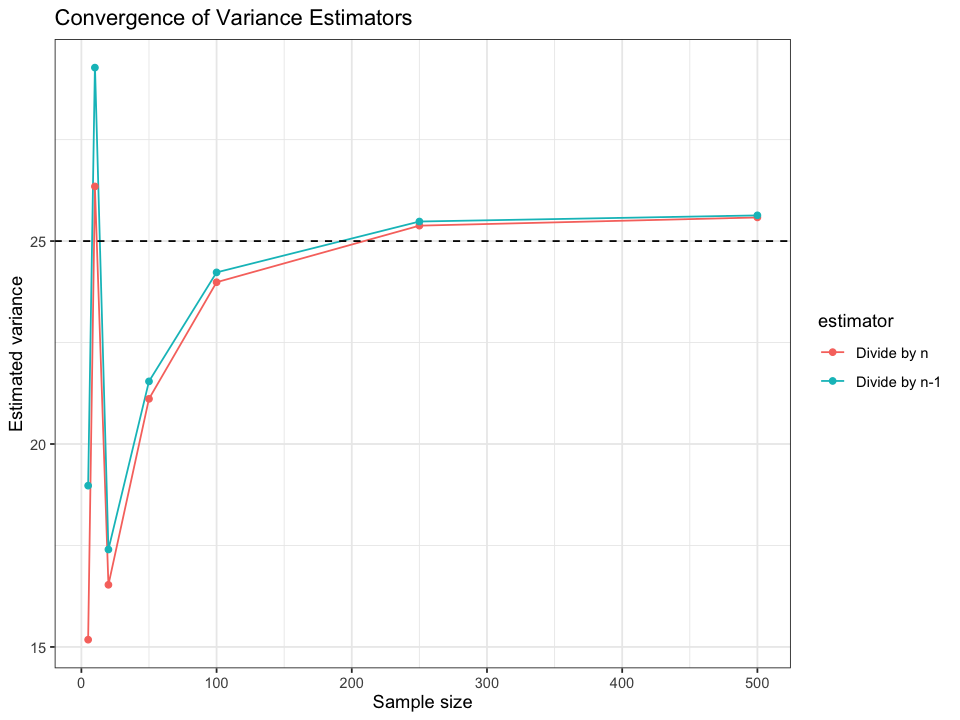

In [63]:
# ---- Plot: Convergence of variance estimators ----
results_long <- results %>%
  tidyr::pivot_longer(var_n:var_n1, names_to = "estimator", values_to = "value") %>%
  dplyr::mutate(estimator = dplyr::recode(estimator, var_n = "Divide by n", var_n1 = "Divide by n-1"))

options(repr.plot.width = 8, repr.plot.height = 6)

ggplot(results_long, aes(n, value, color = estimator)) +
  geom_line() +
  geom_point() +
  geom_hline(yintercept = true_var, linetype = "dashed") +
  labs(title = "Convergence of Variance Estimators", y = "Estimated variance", x = "Sample size")

### Sampling Distributions of Two Asset Returns
We will simulate repeated samples of two (correlated) asset return series and compare the sampling distributions of their sample means and the distribution of the portfolio mean (equal weights).

In [64]:
# ---- Stretch: parameters ----
set.seed(2025)
mu <- c(0.0005, 0.0008)          # daily expected returns
sd_vec <- c(0.02, 0.03)
rho <- 0.9  # increased to 0.90 to demonstrate strong correlation
Sigma2 <- matrix(c(sd_vec[1]^2, rho*prod(sd_vec), rho*prod(sd_vec), sd_vec[2]^2), 2, 2)
B <- chol(Sigma2)

Empirical correlation from demo sample: 0.904 (target rho = 0.90)


`geom_smooth()` using formula = 'y ~ x'


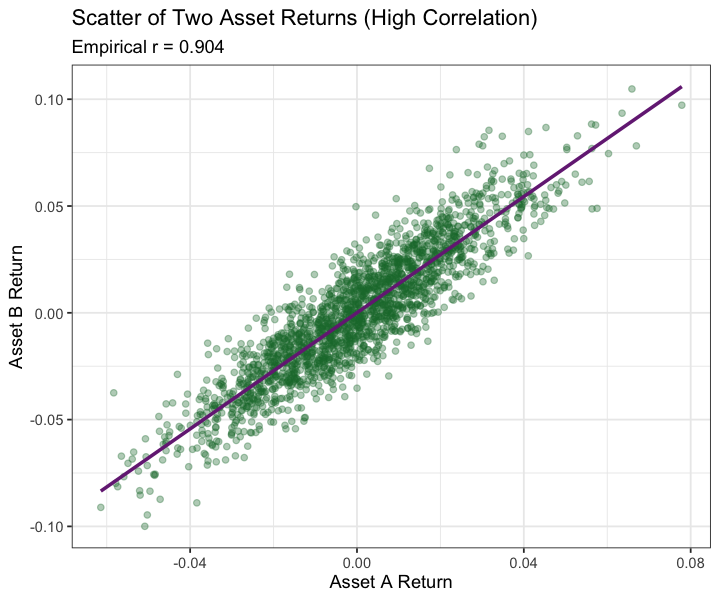

In [65]:
# ---- Stretch: demonstrate high correlation ----
# Single large sample to visualize relationship
N_demo <- 2000
Z_demo <- matrix(rnorm(2*N_demo), N_demo, 2) %*% B
X_demo <- sweep(Z_demo, 2, mu, "+")
assetA_demo <- X_demo[,1]
assetB_demo <- X_demo[,2]

emp_cor <- cor(assetA_demo, assetB_demo)
cat(sprintf('Empirical correlation from demo sample: %.3f (target rho = %.2f)\n', emp_cor, rho))

options(repr.plot.width = 6, repr.plot.height = 5)

ggplot(data.frame(assetA_demo, assetB_demo), aes(assetA_demo, assetB_demo)) +
  geom_point(alpha = 0.35, color = '#1b7837') +
  geom_smooth(method='lm', se=FALSE, color='#762a83') +
  labs(title = 'Scatter of Two Asset Returns (High Correlation)', x='Asset A Return', y='Asset B Return',
       subtitle = paste0('Empirical r = ', round(emp_cor,3)))

### Reflection

How does correlation between assets influence the portfolio mean's variability? Write 3–4 sentences interpreting for a diversified vs concentrated investment decision.